### Read and Prepate the data

#### Import and install libraries


In [ ]:
!pip install arabic_reshaper
!pip install python-bidi

  Created wheel for arabic-reshaper: filename=arabic_reshaper-2.1.0-cp36-none-any.whl size=16502 sha256=c83c976b571da2fdccdf9345ce04dfe0212a85cbe2d34626a9521c8ab9d7b79f
  Stored in directory: /root/.cache/pip/wheels/a9/e6/ec/2ba48138d4447d40442dd6ba3bf6b92d9c6afd74e9c720c6fe
Successfully built arabic-reshaper


In [ ]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.metrics  import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.manifold import TSNE


import csv
import re # for regular expression
import string
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from collections import Counter 

from arabic_reshaper import arabic_reshaper
from bidi.algorithm import get_display

import os

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Read ALL novels

In [ ]:
df_story = pd.read_csv("/content/drive/My Drive/data/Rewayatech/stories.csv", converters={'text': eval})

In [ ]:
df_story.head()

,text,title
0,"[البارت, الاول, وها, اسرد, قصتي, قصتي, بعيون, ...",فتاة الخامسة عشر
1,"[شادن, نشوة, رواء, رفيف, جوري, جالسه, وتامل, د...",تدرِي وش هو القرِف ؟ خاين و يحلف بالشرِف !
2,"[ال, ال, رام, ورواج, ودرب, ودي, اب, وق, ال, اب...",يزيد بي الصوع بذكرى كنت بها المنهاني
3,"[ابطال, الروايه, عائلة, ابو, ركان, ابو, ركان, ...",وشلون تهملني وأنا مهتم فيك هذا السؤال اللي ذ...
4,"[تقول, خلقني, والحزن, توام, محل, رحت, يصير, ال...",ما فادني زينة ما طالني غير شين فعوله


In [ ]:
# Run this cell to convert lists into strings 
df_story['text'] = df_story['text'].apply(lambda x:' '.join(x))

In [ ]:
df_story.count()

text     1269
title    1269
dtype: int64

#### Read ONE novel

In [ ]:
with open('/content/drive/My Drive/data/Rewayatech/novels/تحملت اللي يقولونه و قلت لخاطر عيونه .. و لا قدّر أبد طيبي تفنن هو بتعذيبي.txt', 'r', encoding="utf8", errors='ignore') as f: 
  story = f.readlines()
  
print("Story length in sentences:: {}".format(len(story)))

Story length in sentences:: 9485


#### Clean the novels

##### Cleaning functions

In [ ]:
def remove_value_from_list(story_list, value):
  story_list[:] = (item for item in story_list if item != value)

def remove_value_from_list_end_of_item(story_list, value):
  story_list[:] = (item.strip(value) for item in story_list)

def remove_values_from_list_item(story_list, values):
  story_list[:] = (item.translate(str.maketrans('','',values)) for item in story_list)    

def remove_repeating_char(text):
  return re.sub(r'(.)\1+', r'\1', text)

def remove_hex_char(text):
   t = text.replace('x', 'b')
   print('x')
   #t = re.sub(" \d+", '', t)
   return t

def remove_digits(text):
  return re.sub(r"$\d+\W+|\b\d+\b|\W+\d+$", "", text)
  

def remove_punctuations(text):
    arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
    english_punctuations = string.punctuation
    punctuations_list = arabic_punctuations + english_punctuations
   
    translator = str.maketrans(punctuations_list, ' ' * len(punctuations_list))

    return text.translate(translator)

def remove_single_character(text):
  text = ' '.join([w for w in text.split() if len(w)>1]).strip()
  return text    


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ئ", "ي", text)
    #text = re.sub("ى", "ي", text)
    #text = re.sub("ؤ", "ء", text)
    #text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    #text = re.sub("گ", "ك", text)
    return text


def remove_diacritics(text):
  arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
  text = re.sub(arabic_diacritics, '', text)
  return text   

##### Clean one story

In [ ]:
# remove digits
story = [remove_digits(element) for element in story]

In [ ]:
# remove \n items
remove_value_from_list(story, '\n')
print("Story length in sentences:: {}".format(len(story)))

Story length in sentences:: 6729


In [ ]:
# remove \n at the end of each sentence
remove_value_from_list_end_of_item(story, '\n')

In [ ]:
# remove repeating characters
story = [remove_repeating_char(element) for element in story]

In [ ]:
# remove punctuations
story = [remove_punctuations(element) for element in story]
print("Story length in sentences:: {}".format(len(story)))

Story length in sentences:: 6729


In [ ]:
# remove english letters
remove_values_from_list_item(story, string.ascii_letters)
print("Story length in sentences:: {}".format(len(story)))

Story length in sentences:: 6729


In [ ]:
# remove diacritics
story = [remove_diacritics(element) for element in story]
print("Story length in sentences:: {}".format(len(story)))

Story length in sentences:: 6729


In [ ]:
# normalize letters
story = [normalize_arabic(element) for element in story]
print("Story length in sentences:: {}".format(len(story)))

Story length in sentences:: 6729


In [ ]:
# remove any single arabic letter
story = [remove_single_character(element) for element in story]
print("Story length in sentences:: {}".format(len(story)))

Story length in sentences:: 6729


In [ ]:
# remove arabic (ـ)
remove_values_from_list_item(story, "ـ")
print("Story length in sentences:: {}".format(len(story)))

Story length in sentences:: 6729


In [ ]:
# remove empty lines
story = [element.strip() for element in story]
remove_value_from_list(story, '')
remove_value_from_list(story, ' ')

print("Story length in sentences: {}".format(len(story)))

Story length in sentences: 6071


In [ ]:
# Run this cell to convert lists back to strings 
#story = ' '.join(story)

##### Clean all novels and save as csv

In [ ]:
# Read all novel files

path = "/content/drive/My Drive/data/Rewayatech/novels"
all_files = os.listdir(path)
df_story = pd.DataFrame(columns = ['text','title'])

for i, file in enumerate(tqdm(all_files)):
  if file.endswith('.txt'):
    with open(os.path.join(path, file), encoding="utf8", errors='ignore') as f:
      story = f.readlines()
    title = file[:-4]

    # clean
    remove_value_from_list(story, '\n')   
    story = [remove_punctuations(element) for element in story]
    remove_value_from_list_end_of_item(story, '\n')
    
    remove_values_from_list_item(story, string.ascii_letters)

    story = [normalize_arabic(element) for element in story]
    story = [remove_diacritics(element) for element in story]

    remove_values_from_list_item(story, "ـ")

    story = [remove_repeating_char(element) for element in story]
    story = [word for word in story if word not in stop]
    story = [remove_single_character(element) for element in story]

    story = [element.strip() for element in story]
    remove_value_from_list(story, '')
    story_lines = [line.split() for line in story]
    story = [word for line in story_lines for word in line]
    del story_lines
    story = [word for word in story if word not in stop]

    row = [story, title]
    df_story.loc[i] = row

In [ ]:
df_story.to_csv("stories.csv", index=False)

In [ ]:
from google.colab import files
files.download("/content/stories.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
story = [word for word in tqdm(story) if word not in stop]

#### Tokenization, remove stop words

In [ ]:
# Tokenize words
story_lines = [line.split() for line in story]
story = [word for line in story_lines for word in line]
del story_lines

In [ ]:
# remove stop words
nltk.download('stopwords')
stop = stopwords.words('arabic')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# normalize stop words
stop = [normalize_arabic(element) for element in stop]
stop = set(stop)

In [ ]:
# add more stop words
more_stop_words = set(['اله', 'كل', 'على', 'الي','انت','وانا', 'كانت','شي','يعني', 'البيت',
                   'وهي', 'قلت', 'قالت', 'كنت', 'اني', 'فوق', 'قبل', 'الجزء', 'البارت', 'الاول',
                   'قال', 'وقلت', 'وقالت','شئ','واله','شيء', 'ان','انه', 'واي','انها',
                   'وقال', 'انتي', 'شاء', 'عليها', 'عليه', 'هذا','هو','وهو','مثل',
                    'بيت', 'ابو', 'ام', 'اوكي', 'ال', 'اقول', 'الكل','تقول','يقول',
                     'ان', 'او', 'ا', 'لا', 'في', 'على', 'الى', 'اي', 'تكون', 'كان', 'من', 'اذا', 'مع'])

# 'مو','ليه','شوي', 'بس', 'راح', 'طيب','يلا','خلاص'

stop |= more_stop_words


#### Stemming and lemmatization

In [ ]:
# Apply stemming and lemmatization using Farasa

#!pip install pyarabic

In [ ]:
from farasa.pos import FarasaPOSTagger
from farasa.ner import FarasaNamedEntityRecognizer
from farasa.segmenter import FarasaSegmenter
from farasa.stemmer import FarasaStemmer

In [ ]:
#segmenter = FarasaSegmenter()
farasa_segmenter = FarasaSegmenter(interactive=True)

#for s in story:
#  segmented = segmenter.segment(s)
#  print("sample segmented:",segmented)

[2020-09-06 22:26:57,679 - DEBUG]: perform system check...
[2020-09-06 22:26:57,680 - DEBUG]: check java version...
[2020-09-06 22:26:57,871 - DEBUG]: Your java version is 11.0 which is compatiple with Farasa 
[2020-09-06 22:26:57,872 - DEBUG]: check toolkit binaries...
[2020-09-06 22:26:57,875 - INFO]: Dependencies seem to be satisfied..
[2020-09-06 22:26:57,877 - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
[2020-09-06 22:26:57,880 - INFO]: initializing [SEGMENT] task in INTERACTIVE mode...
[2020-09-06 22:27:02,427 - INFO]: task [SEGMENT] is initialized interactively.


In [ ]:
stemmer = FarasaStemmer()
stemmed = stemmer.stem(story)
print("sample stemmed:",stemmed)

[2020-09-06 19:03:10,393 - DEBUG]: perform system check...
[2020-09-06 19:03:10,395 - DEBUG]: check java version...
[2020-09-06 19:03:10,556 - DEBUG]: Your java version is 11.0 which is compatiple with Farasa 
[2020-09-06 19:03:10,557 - DEBUG]: check toolkit binaries...
[2020-09-06 19:03:10,558 - INFO]: Dependencies seem to be satisfied..
[2020-09-06 19:03:10,562 - INFO]: task [STEM] is initialized in STANDALONE mode...


sample stemmed: أبو ماجد عمر 54 في عصبي شوي بس ان من داخل حنون ام ماجد عمر 49 حنون مر طيب مات في عيال واي شي تمنى أجاب ل ماجد ابن أكبر عمر 20 طايش مر واهم ما عند بنت ساعد جمال ان علق بنت في اسمر طويل جسم رياضي عين كبير ل سكسوك واي بنت تخق على نور عمر 17 طيب مر بس بعض أمر تعصب على مات في اخوان مر حلو بيض طويل جسم رشيق علطول دخل في قلب ناصر عمر 14 مر خجول شكل مو طبيعي استحيى من اي شي أحب بنت عم سار بس محد درى عن الا نور هو مو جميل مر بس ان ملوح مو جميل دان عمر مزعج مر أحب اخت نور مر بس بعض يام قهر ماجد جالس في صاله مع جوال لعب في جت نور عند نور ماجد شفت ابتوبي ماجد لا اله اسيل ناصر أمكن مع نور طيب أنت خلك مع بنت الي لعب على راح غرفة ناصر قال ل صور شفت ابتوب حق ناصر أي روح حق على شفت دان ماسك داخل غرفة نور أوهى ياويلي راح ابتوبي راح ركض ناصر ضحك على نور تصارخ دان دان دخل غرفة دان قت قاعد رسم على ابتوب صارخ قال الا ابتوبي دانو ياويلك اذ خرب حق اهى دان روح ماحبك روح اهى اهى نور شافي حن على قال دنو حبيب أنا احبك بس أنا قال كذا علشان ماتسو كذا مر ثاني دان مسح دمعة طيب خلاص مالاح اسوي شي روح ن

In [ ]:
#pos_tagger = FarasaPOSTagger()
#pos_tagged = pos_tagger.tag(story)
#print("sample POS Tagged",pos_tagged)

[2020-09-06 18:50:26,217 - DEBUG]: perform system check...
[2020-09-06 18:50:26,218 - DEBUG]: check java version...
[2020-09-06 18:50:26,355 - DEBUG]: Your java version is 11.0 which is compatiple with Farasa 
[2020-09-06 18:50:26,357 - DEBUG]: check toolkit binaries...
[2020-09-06 18:50:26,360 - INFO]: Dependencies seem to be satisfied..
[2020-09-06 18:50:26,364 - INFO]: task [POS] is initialized in STANDALONE mode...


sample POS Tagged S/S ماجد/NOUN-MS عمر/NOUN-MS +ه/PRON 54/NUM-MP و+/CONJ في/PREP عصبي/NOUN-MS +ه/PRON شوي/NOUN-MS داخل/NOUN-MS +ه/PRON حنون/NOUN-MS ماجد/NOUN-MS عمر/NOUN-MS +ها/PRON 49/NUM-MP و+/CONJ حنون/NOUN-MS +ه/PRON مر/NOUN-MS +ه/PRON و+/CONJ طيب/NOUN-MS +ه/PRON و+/CONJ تموت/NOUN-MS عيال/NOUN-FP +ها/PRON يتمن/V +ون/PRON +ه/PRON تجيب/V +ه/PRON ماجد/NOUN-MS ال+/DET ابن/NOUN-MS ال+/DET أكبر/ADJ-MS عمر/NOUN-MS 20/NUM-MP و+/CONJ طايش/V مر/NOUN-MS +ه/PRON واهم/ADJ-MS عند/NOUN-MS +ه/PRON ال+/DET بن/NOUN-FP +ات/NSUFF و+/CONJ يساعد/V +ه/PRON جمال/NOUN-MS +ه/PRON يعلق/V بنت/NOUN-MS اسمر/NOUN-MS طويل/ADJ-MS جسم/NOUN-MS +ه/PRON رياضي/NOUN-FP عيون/NOUN-FP +ه/PRON كبار/ADJ-MP سكسوك/NOUN-MS +ه/PRON بنت/NOUN-MS تخق/NOUN-MS نورا/NOUN-MS عمر/NOUN-MS +ها/PRON 17/NUM-MP طيب/NOUN-MS +ه/PRON مر/NOUN-MS +ه/PRON ال+/DET أمور/NOUN-FP تعصب/NOUN-MS و+/CONJ تموت/NOUN-MS اخوان/NOUN-MP +ها/PRON و+/CONJ مر/NOUN-MS +ه/PRON حلو/NOUN-MS +ه/PRON بيض/NOUN-MS +ا/CASE و+/CONJ طويل/ADJ-MS +ه/PRON و+/CONJ جسم/NOUN-MS +ه

### 1. Characters Extraction

#### Extract names from wikipedia

In [ ]:
# Import names from wikipedia

from bs4 import BeautifulSoup
import requests
url = "https://ar.wikipedia.org/w/index.php?title=تصنيف:أسماء_إناث_عربية&pagefrom=ميرا+%28اسم%29#mw-pages"
r = requests.get(url)
html_doc = r.text
soup = BeautifulSoup(html_doc)

In [ ]:
female_names = []
for link in soup.find_all('a'):
  female_names.append(link.get('title'))


#### Extract characters from each story

In [ ]:
# Read male and female names corpus

with open('/content/drive/My Drive/data/Rewayatech/additional_data/female_names.txt', 'r') as f: 
  female_names = f.readlines()
# دلال
with open('/content/drive/My Drive/data/Rewayatech/additional_data/male_names.txt', 'r') as f: 
  male_names = f.readlines()  

In [ ]:
# Clean and normalize names

remove_value_from_list_end_of_item(female_names, '\n')
remove_value_from_list_end_of_item(male_names, '\n')

#  names
female_names = [normalize_arabic(element) for element in female_names]
male_names = [normalize_arabic(element) for element in male_names]


female_names = [element.strip() for element in female_names]
male_names = [element.strip() for element in male_names]


In [ ]:
# Prepare dataframe to extract characters for each novel 

df_names = pd.DataFrame(columns=['title', 'names', 'count']) 
df_names['title'] = df_story['title']

In [ ]:
# for all novels count top 30 words and store them if they are names

from collections import Counter

for i, s in tqdm(enumerate(df_story['text'])):
  counter = Counter(s)
  top_30_words = counter.most_common(30)
  top_names = []
  top_names_count = []
  for (name, count) in top_30_words:
    if name in (female_names + male_names):
      top_names.append(name)
      top_names_count.append(count)

  df_names.iloc[i]['names'] = top_names
  df_names.iloc[i]['count'] = top_names_count

In [ ]:
df_names.tail()

,title,names,count
1264,تكفى ياولد الأجواد علمني منو أبوي ومنو أمي,"[جود, مشعل, غناء, مشاعل, فهد, سناء, بدر, مها, ...","[1200, 1192, 922, 760, 587, 570, 420, 393, 366..."
1265,ياسادة العشق يكفي للحب مدية كفي,"[نوره, خالد, ابراهيم, فاطمه, ريم, ماجد, علي, م...","[498, 325, 74, 60, 55, 47, 47, 44, 37, 32, 31,..."
1266,تصدقون زميلتي طلعت ولد,"[هند, ساره]","[61, 44]"
1267,الحديقة السرية,"[حور, ياسر, جنا, بندر, تركي, هدى, نايف, مي, هن...","[1474, 1270, 583, 226, 224, 205, 192, 186, 185..."
1268,أنا شوقي يزيد هيام كثر ما روحي عشقانة و أنا ...,"[امل, اروى, ندى, خلود, مراد, فهد, احمد, جواد, ...","[823, 512, 452, 375, 324, 286, 278, 255, 100]"


In [ ]:
df_names.to_csv("titles_names_count.csv", index=False)

#### Analyze the characters

In [ ]:
df_names = pd.read_csv('/content/drive/My Drive/data/Rewayatech/additional_data/titles_names_count.csv', converters={'names': eval})

In [ ]:
df_names.head()

,title,names,count
0,فتاة الخامسة عشر,"[نواف, محمد, خالد, روان]","[169, 83, 31, 29]"
1,تدرِي وش هو القرِف ؟ خاين و يحلف بالشرِف !,"[شادن, رواء, مساعد, سعود, فيصل, ود, رفيف]","[696, 610, 355, 334, 124, 90, 65]"
2,يزيد بي الصوع بذكرى كنت بها المنهاني,"[غانم, حميد, مها, عبيد, مهره, راشد]","[1314, 299, 248, 170, 145, 136]"
3,وشلون تهملني وأنا مهتم فيك هذا السؤال اللي ذ...,"[قصي, ساره, ركان, سامي, اياد, بسام, شهد, عمر, ...","[1361, 725, 417, 309, 250, 163, 163, 111, 85, 82]"
4,ما فادني زينة ما طالني غير شين فعوله,"[حمد, خلود, ندى, مبارك, شوق, سعود, علي, ساره]","[670, 189, 179, 176, 115, 104, 102, 61]"


In [ ]:
# Find the number of characters in each story
df_names['characters_number'] = df_names['names'].apply(lambda x: len(x))

In [ ]:
# Find the story with highest number of characters
df_names['title'][df_names['characters_number']== df_names['characters_number'].max()]

278    رواية جاني قال أحبك بعد ما أهاني و داس كرامت...
Name: title, dtype: object

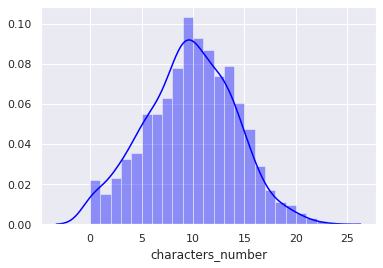

In [ ]:
# Plot the number of characters for
sns.distplot(df_names['characters_number'] , color="blue", bins = 23, kde= True)

In [ ]:
# study the correlation between story length and the number of character
df_names['story_length'] = df_story['text'].apply(lambda x: len(x))

In [ ]:
df_names['characters_number'][df_names['characters_number']!= 0].corr(df_names['story_length'], method='pearson')

0.2022637580882161

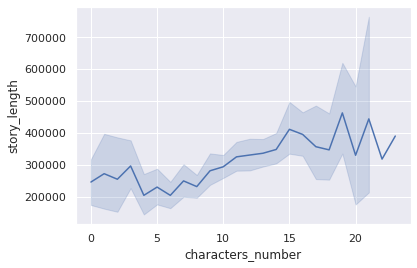

In [ ]:
# Plot the correlation

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

ax = sns.lineplot(x=df_names['characters_number'], y=df_names['story_length'],
                     palette=cmap, sizes=(10, 200))

#### Find the top male and female names

In [ ]:
df_names.head()

,title,names,count,characters_number
0,فتاة الخامسة عشر,"[نواف, محمد, خالد, روان]","[169, 83, 31, 29]",4
1,تدرِي وش هو القرِف ؟ خاين و يحلف بالشرِف !,"[شادن, رواء, مساعد, سعود, فيصل, ود, رفيف]","[696, 610, 355, 334, 124, 90, 65]",7
2,يزيد بي الصوع بذكرى كنت بها المنهاني,"[غانم, حميد, مها, عبيد, مهره, راشد]","[1314, 299, 248, 170, 145, 136]",6
3,وشلون تهملني وأنا مهتم فيك هذا السؤال اللي ذ...,"[قصي, ساره, ركان, سامي, اياد, بسام, شهد, عمر, ...","[1361, 725, 417, 309, 250, 163, 163, 111, 85, 82]",10
4,ما فادني زينة ما طالني غير شين فعوله,"[حمد, خلود, ندى, مبارك, شوق, سعود, علي, ساره]","[670, 189, 179, 176, 115, 104, 102, 61]",8


In [ ]:
# most common female and male name
all_names = df_names['names'].sum()

In [ ]:
name_counter = Counter(all_names)
top_50_names = name_counter.most_common(50)

top_names = []
top_names_count = []
for (name, count) in top_50_names:
  top_names.append(name)
  top_names_count.append(count)

In [ ]:
top_male_names = []
top_male_count = []
top_female_names = []
top_female_count =[]

for i, n in enumerate(top_50_names):
  if n[0] in male_names:
    top_male_names.append(n[0])
    top_male_count.append(n[1])
    
  if n[0] in female_names:
    top_female_names.append(n[0])
    top_female_count.append(n[1])


Text(0.5, 1.0, 'Most common male names in novels')

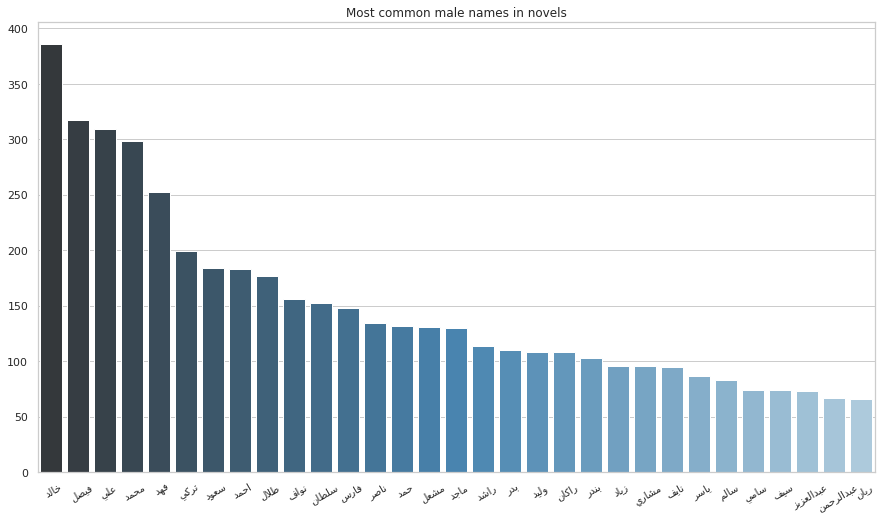

In [ ]:
# plot most common male names
labels = [get_display(arabic_reshaper.reshape(s.encode().decode('utf8'))) for s in top_male_names]
values = top_male_count
indexes = np.arange(len(labels))
width = 1

sns.set(style='whitegrid', rc={'figure.figsize':(15,8.27)})

ax = sns.barplot(indexes, values, palette= "Blues_d")
plt.xticks(indexes + width * 0.1, labels, rotation = 30)
plt.tick_params(axis='x', labelsize=10)
plt.title("Most common male names in novels")

Text(0.5, 1.0, 'Most common female names in novels')

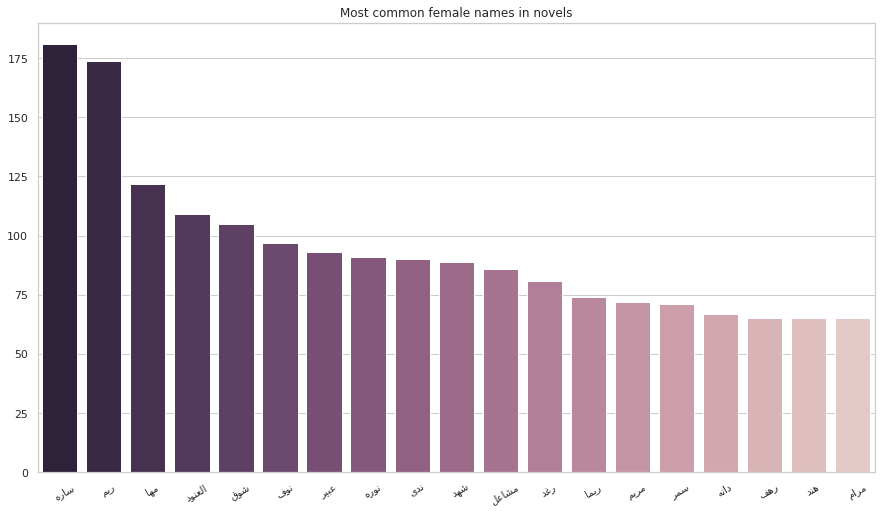

In [ ]:
# Plot most common female names
labels = [get_display(arabic_reshaper.reshape(s.encode().decode('utf8'))) for s in top_female_names]
values = top_female_count
indexes = np.arange(len(labels))
width = 1

sns.set(style='whitegrid', rc={'figure.figsize':(15,8.27)})
ax = sns.barplot(indexes, values, palette= sns.cubehelix_palette(20, reverse=True))
plt.xticks(indexes + width * 0.1, labels, rotation = 30)
plt.tick_params(axis='x', labelsize=10)
plt.title("Most common female names in novels")

In [ ]:
temp_top_female_names = sum([[n] * c for n, c in zip(top_female_names, top_female_count)], [])
temp_top_female_names = ' '.join(temp_top_female_names)

In [ ]:
temp_top_male_names = sum([[n] * c for n, c in zip(top_male_names, top_male_count)], [])
temp_top_male_names = ' '.join(temp_top_male_names)

(-0.5, 699.5, 299.5, -0.5)

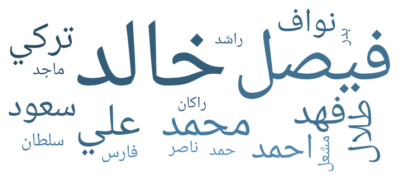

In [ ]:
# Plot the word-cloud for male names

reshaped_texts = arabic_reshaper.reshape(temp_top_male_names)
arabic_texts = get_display(reshaped_texts)


wordcloud = WordCloud(font_path='/content/drive/My Drive/data/Rewayatech/NotoNaskhArabic-Regular.ttf', mode="RGBA",max_words=19, width=700,
                      collocations = False, height=300, background_color="white", font_step=25, max_font_size=200).generate(arabic_texts)


# create coloring from image
color_mask = np.array(Image.open('/content/drive/My Drive/data/Rewayatech/additional_data/male_palette.png'))
image_colors = ImageColorGenerator(color_mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

#wordcloud.to_file("img/first_review.png")

#### Construct character interaction network



In [ ]:
df_names =  pd.read_csv("/content/drive/My Drive/data/Rewayatech/additional_data/titles_names_count.csv", converters={'names': eval, 'count': eval})

In [ ]:
df_names.head()

,title,names,count
0,فتاة الخامسة عشر,"[نواف, محمد, خالد, روان]","[169, 83, 31, 29]"
1,تدرِي وش هو القرِف ؟ خاين و يحلف بالشرِف !,"[شادن, رواء, مساعد, سعود, فيصل, ود, رفيف]","[696, 610, 355, 334, 124, 90, 65]"
2,يزيد بي الصوع بذكرى كنت بها المنهاني,"[غانم, حميد, مها, عبيد, مهره, راشد]","[1314, 299, 248, 170, 145, 136]"
3,وشلون تهملني وأنا مهتم فيك هذا السؤال اللي ذ...,"[قصي, ساره, ركان, سامي, اياد, بسام, شهد, عمر, ...","[1361, 725, 417, 309, 250, 163, 163, 111, 85, 82]"
4,ما فادني زينة ما طالني غير شين فعوله,"[حمد, خلود, ندى, مبارك, شوق, سعود, علي, ساره]","[670, 189, 179, 176, 115, 104, 102, 61]"


In [ ]:
# Choose novel number to construct interaction network
novel_no = 278

In [ ]:
# Extract main characters and their occurrence in the story
characters = df_names['names'][novel_no].copy()
top_names_count = df_names['count'][novel_no]

['منصور',
 'فهد',
 'هاني',
 'ماجد',
 'راكان',
 'سلطان',
 'نادر',
 'وسام',
 'نرجس',
 'شجن',
 'نجود',
 'مرام',
 'رحاب',
 'فاديه',
 'ابراهيم',
 'افنان',
 'بندر',
 'نايف',
 'بتول',
 'عبدالعزيز',
 'مها',
 'محمود',
 'ناصر']

In [ ]:
# Extract the story
story = df_story.iloc[novel_no]['text']

In [ ]:
# Computer the interaction between characters

window_size = 5

def compute_interaction(character, other_characters):
  other_characters = other_characters[::-1]
  character_index = [i for i, e in enumerate(story) if e == character]
  hit = 0
  for p in other_characters:
    for i in character_index:
      start = max(0, i-window_size)
      sentence = story[start:i+window_size+ 1]
      if p in sentence:
        hit += 1
    if hit !=0:
      interaction_list.append([character, p, hit])
  return interaction_list  

In [ ]:
interaction_list = list()

while characters:
 character = characters.pop()
 compute_interaction(character, characters)

In [ ]:
interaction_list

[['ناصر', 'مها', 3],
 ['ناصر', 'عبدالعزيز', 4],
 ['ناصر', 'بتول', 4],
 ['ناصر', 'نايف', 5],
 ['ناصر', 'بندر', 7],
 ['ناصر', 'افنان', 7],
 ['ناصر', 'ابراهيم', 8],
 ['ناصر', 'فاديه', 8],
 ['ناصر', 'رحاب', 9],
 ['ناصر', 'مرام', 11],
 ['ناصر', 'نجود', 11],
 ['ناصر', 'شجن', 11],
 ['ناصر', 'نرجس', 11],
 ['ناصر', 'وسام', 164],
 ['ناصر', 'نادر', 164],
 ['ناصر', 'سلطان', 165],
 ['ناصر', 'راكان', 165],
 ['ناصر', 'ماجد', 165],
 ['ناصر', 'هاني', 171],
 ['ناصر', 'فهد', 171],
 ['ناصر', 'منصور', 171],
 ['محمود', 'بتول', 199],
 ['محمود', 'نايف', 200],
 ['محمود', 'بندر', 200],
 ['محمود', 'افنان', 202],
 ['محمود', 'ابراهيم', 203],
 ['محمود', 'فاديه', 203],
 ['محمود', 'رحاب', 203],
 ['محمود', 'مرام', 204],
 ['محمود', 'نجود', 208],
 ['محمود', 'شجن', 208],
 ['محمود', 'نرجس', 208],
 ['محمود', 'وسام', 208],
 ['محمود', 'نادر', 209],
 ['محمود', 'سلطان', 209],
 ['محمود', 'راكان', 217],
 ['محمود', 'ماجد', 217],
 ['محمود', 'هاني', 218],
 ['محمود', 'فهد', 219],
 ['محمود', 'منصور', 219],
 ['مها', 'بندر', 1],
 ['مها

In [ ]:
# Save it as a dataframe
interaction_df = pd.DataFrame(interaction_list, columns=['source', 'target', 'weight'])
interaction_df['weight_inv'] = 1/interaction_df.weight
interaction_df.head(20)

,source,target,weight,weight_inv
0,ناصر,مها,3,0.333333
1,ناصر,عبدالعزيز,4,0.250000
2,ناصر,بتول,4,0.250000
3,ناصر,نايف,5,0.200000
4,ناصر,بندر,7,0.142857
5,ناصر,افنان,7,0.142857
6,ناصر,ابراهيم,8,0.125000
7,ناصر,فاديه,8,0.125000
8,ناصر,رحاب,9,0.111111
9,ناصر,مرام,11,0.090909


In [ ]:
# Create a graph 

import networkx as nx
import plotly.graph_objects as go


# Creating an empty graph object
G = nx.Graph()

In [ ]:
# Iterating through the DataFrame to add edges
for _, edge in interaction_df.iterrows():
    source = get_display(arabic_reshaper.reshape(edge['source']))
    target = get_display(arabic_reshaper.reshape(edge['target']))
    G.add_edge(source, target, weight=edge['weight'])

In [ ]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 23
Number of edges: 247
Average degree:  21.4783


In [ ]:
# Characters name
characters = df_names.iloc[novel_no]['names'].copy() 

In [ ]:
# Use count for the node size 
n_size = [i for i in top_names_count]
n_size = list(reversed(n_size))

In [ ]:
# Set the color based on the character sex

n_color = ['pink' if i in female_names else 'skyblue' for i in characters]
n_color

['skyblue',
 'skyblue',
 'skyblue',
 'skyblue',
 'skyblue',
 'skyblue',
 'skyblue',
 'pink',
 'pink',
 'pink',
 'pink',
 'pink',
 'pink',
 'pink',
 'skyblue',
 'pink',
 'skyblue',
 'skyblue',
 'pink',
 'skyblue',
 'pink',
 'skyblue',
 'skyblue']

In [ ]:
#reserved_n_color = list(reversed(n_color))
#reserved_n_color

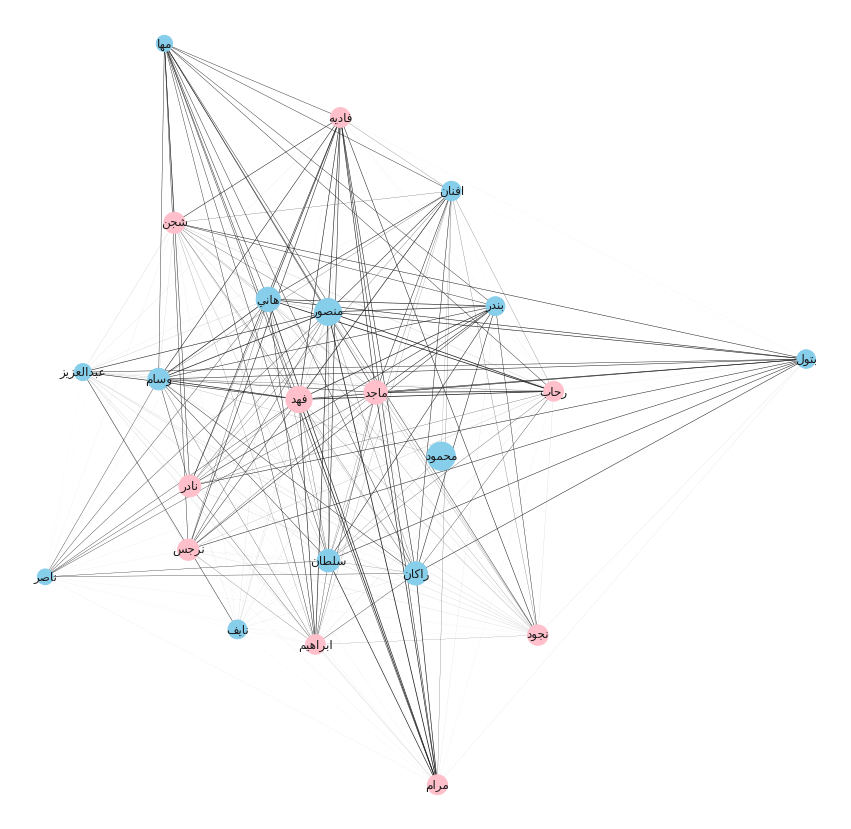

In [ ]:
# Plot the interaction network

plt.figure(figsize=(15, 15))
plt.axis('off')
plt.grid(b=None)
nx.draw_networkx(G, node_color=n_color, node_size=n_size ,width=interaction_df['weight']/500, edge_cmap=plt.cm.Blues)

#### Analyzing Graph

In [ ]:
# Measuring the importance of a node in a network
# Using: degree_centrality

# Calculating the degree centrality
deg_cen = nx.degree_centrality(G)

# Sorting the dictionaries according to their degree centrality and storing the top 10
sorted_deg_cen = sorted(deg_cen.items(), key=lambda x:x[1], reverse=True)[0:10]

# Printing out the top 10 of book1 and book5
print(sorted_deg_cen)

[('ﻕﺭﺎﻃ', 1.0), ('ﺯﺍﻮﻓ', 1.0), ('ﺮﻳﺎﺸﺑ', 1.0), ('ﺮﺳﺎﻳ', 1.0), ('ﻥﺎﻨﻓﺍ', 1.0), ('ﻞﺼﻴﻓ', 0.9090909090909092), ('ﺱﺍﺮﻓ', 0.9090909090909092), ('ﺪﻤﺤﻣ', 0.9090909090909092), ('ﺪﻟﺎﺧ', 0.9090909090909092), ('ﺭﺍﺮﺑﺍ', 0.9090909090909092)]


In [ ]:
G_inv = nx.Graph()

# Iterating through the DataFrame to add edges
for _, edge in interaction_df.iterrows():
    source = get_display(arabic_reshaper.reshape(edge['source']))
    target = get_display(arabic_reshaper.reshape(edge['target']))
    G_inv.add_edge(source, target, weight=edge['weight_inv'])

In [ ]:
# Measuring the importance of a node in a network
# Using: Betweeness centrality
# This method finds nodes which are important in the network. A centrality method like Betweeness centrality finds nodes 
# which are structurally


sorted(nx.betweenness_centrality(G).items(),
       key=lambda x:x[1], reverse=True)[0:13]

[('ﻕﺭﺎﻃ', 0.010981240981240982),
 ('ﺯﺍﻮﻓ', 0.010981240981240982),
 ('ﺮﻳﺎﺸﺑ', 0.010981240981240982),
 ('ﺮﺳﺎﻳ', 0.010981240981240982),
 ('ﻥﺎﻨﻓﺍ', 0.010981240981240982),
 ('ﻞﺼﻴﻓ', 0.009163059163059163),
 ('ﺱﺍﺮﻓ', 0.009163059163059163),
 ('ﺭﺍﺮﺑﺍ', 0.006363636363636363),
 ('ﺪﻤﺤﻣ', 0.0038383838383838384),
 ('ﺪﻟﺎﺧ', 0.0038383838383838384),
 ('ﻥﺍﻭﺭ', 0.0018181818181818182),
 ('ﻱﺭﻮﺟ', 0.0018181818181818182)]

In [ ]:
# Let's care about interactions now

sorted(nx.betweenness_centrality(G_inv,
       weight='weight_inv').items(),
       key=lambda x:x[1], reverse=True)[0:12]

[('ﻕﺭﺎﻃ', 0.010981240981240982),
 ('ﺯﺍﻮﻓ', 0.010981240981240982),
 ('ﺮﻳﺎﺸﺑ', 0.010981240981240982),
 ('ﺮﺳﺎﻳ', 0.010981240981240982),
 ('ﻥﺎﻨﻓﺍ', 0.010981240981240982),
 ('ﻞﺼﻴﻓ', 0.009163059163059163),
 ('ﺱﺍﺮﻓ', 0.009163059163059163),
 ('ﺭﺍﺮﺑﺍ', 0.006363636363636363),
 ('ﺪﻤﺤﻣ', 0.0038383838383838384),
 ('ﺪﻟﺎﺧ', 0.0038383838383838384),
 ('ﻥﺍﻭﺭ', 0.0018181818181818182),
 ('ﻱﺭﻮﺟ', 0.0018181818181818182)]

### 2. Dialect Detection

##### Create dialect annotation file

This file is created using weakly supervised labeling with few manual annotation

In [ ]:
def detect_dialect(story, dialect_words):
    count=0
    # loop through the list of words and see if they are in the dialect text
    for word in story:
      if word in dialect_words:
        count+=1
    
    return count

In [ ]:
### Weakly auto-label the novels

uae_words = ['الساع','شحالك', 'شحالج', 'امايه', 'يرمس']
fusha_words = ['أريد','لقد', '']
iraq_words = ['فد', 'هسه', 'هسة']
khalij_words = ['احبج', 'لج', 'عندج', 'شنو']
saudi_words = ['عليتس','عندس', 'عندتس','احبتس']

In [ ]:
df_dialects = pd.DataFrame(columns=['title', 'uae', 'fusha', 'iraqi','khaliji','saudi']) 
df_dialects['title'] = df_story['title']

In [ ]:
df_dialects['uae'] = df_story['text'].apply(lambda x: detect_dialect(x, uae_words))

In [ ]:
df_dialects['uae'][df_dialects['uae'] <= 10] = 0
df_dialects['uae'][df_dialects['uae'] > 10] = 1

In [ ]:
df_dialects['fusha'] = df_story['text'].apply(lambda x: detect_dialect(x, fusha_words))

In [ ]:
df_dialects['fusha'][df_dialects['fusha'] <= 10] = 0
df_dialects['fusha'][df_dialects['fusha'] > 10] = 1

In [ ]:
df_dialects['iraqi'] = df_story['text'].apply(lambda x: detect_dialect(x, iraq_words))

In [ ]:
df_dialects['iraqi'][df_dialects['iraqi'] <= 10] = 0
df_dialects['iraqi'][df_dialects['iraqi'] > 10] = 1

In [ ]:
df_dialects['khaliji'] = df_story['text'].apply(lambda x: detect_dialect(x, kuwait_words))

In [ ]:
df_dialects['khaliji'][df_dialects['khaliji'] <= 10] = 0
df_dialects['khaliji'][df_dialects['khaliji'] > 10] = 1

In [ ]:
df_dialects['saudi'] = df_story['text'].apply(lambda x: detect_dialect(x, khalij_words))

In [ ]:
df_dialects['saudi'] [df_dialects['saudi']  < 10] = 0
df_dialects['saudi'] [df_dialects['saudi']  > 10] = 1

In [ ]:
df_dialects.to_csv("titles_dialects.csv", index=False)

#### Dialects Detection

In [ ]:
# Read Weakly annotatation files
df_annotation = pd.read_csv('/content/drive/My Drive/data/Rewayatech/titles_dialects_final.csv')

In [ ]:
df_annotation.head()

,title,uae,fusha,iraqi,khaliji,saudi
0,فتاة الخامسة عشر,0,1,0,0,0
1,تدرِي وش هو القرِف ؟ خاين و يحلف بالشرِف !,0,0,0,0,0
2,أمـوت ولا أموت ولا انتـظر موتي ؟,1,0,0,0,0
3,وشلون تهملني وأنا مهتم فيك هذا السؤال اللي ذ...,0,0,0,0,1
4,ما فادني زينة ما طالني غير شين فعوله,0,0,0,0,0


In [ ]:
df_annotation.count()

title      1237
uae        1237
fusha      1237
iraqi      1237
khaliji    1237
saudi      1237
dtype: int64

In [ ]:
# Merge df_story and df_annotation
df_dialects = pd.merge(df_story, df_annotation, on="title") 

In [ ]:
# Remove unlabeled novels
df_dialects['sum'] =  df_dialects[['uae', 'fusha', 'iraqi','khaliji','saudi']].sum(axis=1) 
df_dialects.drop(df_dialects.loc[df_dialects['sum']==0].index, inplace=True)

In [ ]:
# Number of annotated novels
df_dialects.count()

text       530
title      530
uae        530
fusha      530
iraqi      530
khaliji    530
saudi      530
sum        530
dtype: int64

In [ ]:
# Run this cell to convert lists into strings 

#df_dialects['text'] = df_dialects['text'].apply(lambda x:' '.join(x))

In [ ]:
# Map 0 and 1 in annotation file into numbers {0, 1, 2, 3, 4, 5}

def map_label(u, f, i, k, s):
  if u == 1:
    return 0
  elif f == 1:
    return 1
  elif i == 1:
    return 2
  elif k == 1:
    return 3  
  elif s == 1:
    return 4                    

In [ ]:
df_dialects['target'] = df_dialects.apply(lambda row: map_label(row['uae'],  row['fusha'], row['iraqi'], row['khaliji'], row['saudi']), axis = 1)

In [ ]:
# Prepare data for training
X_train, X_test, y_train, y_test = train_test_split(df_bert['text'], df_bert['target'], test_size=0.2, 
                                                    random_state=0, stratify=df_bert['target'])

In [ ]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Test_Y = Encoder.fit_transform(y_test)

In [ ]:
# Apply TfidfVectorizer on the text

Tfidf_vect = TfidfVectorizer(max_features=500)

Tfidf_vect.fit(df_dialects['text'])
Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [ ]:
# TSNE for visualizing
tsne = TSNE(n_components= 2, random_state=0)
tsne_obj = tsne.fit_transform(Train_X_Tfidf)

In [ ]:
df_tsne = pd.DataFrame({'X':tsne_obj[:,0], 'Y':tsne_obj[:,1],'target': y_train})

In [ ]:
# for visualizing legend
df_tsne['label'] = df_tsne['target']
df_tsne['label'] = df_tsne['label'].map({0: 'UAE', 1: 'Fusha', 2: 'Iraqi', 3: 'Khaliji', 4: 'Saudi'})

In [ ]:
df_tsne.label.value_counts()

Saudi      173
Khaliji    131
UAE         89
Fusha       26
Iraqi        5
Name: label, dtype: int64

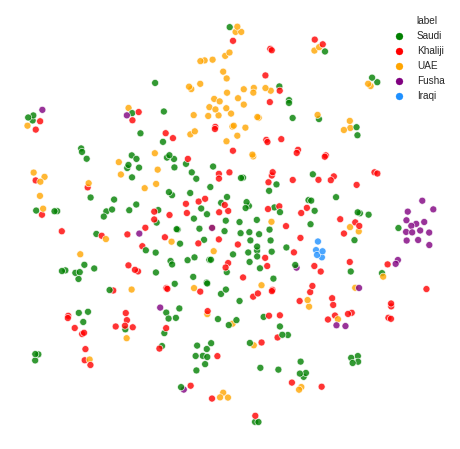

In [ ]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.grid(b=None)

sns.scatterplot(x ='X', y ='Y', hue='label', legend='full', palette=['green','red','orange','purple','dodgerblue'],
                alpha = 0.8, data=df_tsne)


In [ ]:
from sklearn.naive_bayes import GaussianNB

#Create a Gaussian Classifier
nb_model = GaussianNB()

# Train the model using the training sets
nb_model.fit(Train_X_Tfidf.todense(), Train_Y)

#Predict Output
predictions_NB= nb_model.predict(Test_X_Tfidf.todense())
print ("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y) * 100)

Naive Bayes Accuracy Score ->  72.64150943396226
